# Applying the deflection angles to CMB maps
**Importing libraries**

In [135]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import mass_defs
from colossus.halo import mass_so
from scipy.ndimage import gaussian_filter

dpi = 160 #figures' dots per inch

**Defining constants**

$\lambda$-CDM parameters from [https://en.wikipedia.org/wiki/Lambda-CDM_model](https://en.wikipedia.org/wiki/Lambda-CDM_model)

In [136]:
H_o = 67.74       #Hubble constant in km s^−1 Mpc^−1
h = H_o/100       #scaled Hubble constant 
omega_m = 0.3089  #matter density parameter 
omega_l = 0.6911  #vacuum density parameter

c = 2.99792458e5  #speed of light in km/s                     
G = 4.30091 * 10**(-3) / (10**(6))   #Gavitational constant in Mpc M_sun^−1  (km/s)^2

**Defining functions for**
1. Comoving distance
2. Hubble parameter
3. Critical density
4. r$_{200}$
5. Concentration
6. Scale radius
7. Density parameter
8. NFW density profile
9. NFW mass profile

In [137]:
cosmology.setCosmology('planck18')

def comov_dist_func(z):                   #comoving distance in Mpc using Eq. 4.53 in Peter (2015)
    return (c/H_o) * integrate.quad(lambda a: 1/np.sqrt(a * omega_m +  a**4 * omega_l), np.power(1+z,-1), 1)[0]

def H(z):                                 #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 

def rho_cric_func(z):                    #critical density in M_sun Mpc^-3
    return 3 * H(z)**2 / (8 * np.pi * G) 



def r_200(M_200, z_l):                   #r_200c in Mpc. Output of M_to_R is in kpc/h.
    return mass_so.M_to_R(M_200, z_l, '200c') * h / 10**3    

def c_200_func(M_200, z_l):
    return concentration.concentration(M_200, '200c', z_l, model = 'diemer15') 

def R_s_func(M_200, z_l, c_200 = 0):      #Scale radius in Mpc
    if c_200 == 0:
        c_200 = c_200_func(M_200, z_l)

    return r_200(M_200, z_l)/c_200 

def rho_o_func(M_200, z_l, c_200 = 0):   #density paremter (in M_sun Mpc^-3) from eq. next to eq. 7.61 in Peter's book 
    if c == 0:
        c_200 = c_200_func(M_200, z_l) 

    return 200/3 * rho_cric_func(z_l)  * np.power(c_200, 3) / ( np.log(1+c_200) - c_200/(1+c_200) )

def rho(r, M_200, z_l):                  #NFW Density Profile (in M_sun Mpc^-3)
    R_s = R_s_func(M_200, z_l)  
    return rho_o_func(M_200, z_l) / ((r/R_s)*(1+(r/R_s))**2 ) 

def M(r, M_200, z_l, rho = 'no'):        #NFW Mass profile in M_sun from https://en.wikipedia.org/wiki/Navarro–Frenk–White_profile
    R_s = R_s_func(M_200, z_l) 
    return 4 * np.pi * rho_o_func(M_200, z_l) * np.power(R_s,3) * (np.log((R_s + r)/R_s) - r/ (R_s + r)) 

**Dodelson (2003) functions**

In [138]:
cosmology.setCosmology('planck18')
def lambda_func(theta, M_200, z_l):
    X_l = comov_dist_func(z_l)
    return X_l * theta / ((1+z_l) * R_s_func(M_200, z_l)) 

def f_func(theta, M_200, z_l):
    Lambda = lambda_func(theta, M_200, z_l)         #parameter in Dodelson (2003)

    f = np.zeros(np.shape(theta))                   #parameter in Dodelson (2003)
    
    if theta.ndim == 2:
        for i in range(np.shape(Lambda)[0]):
            for j in range(np.shape(Lambda)[1]):   
                if Lambda[i][j] < 1:
                    f[i][j] = (3.23 / Lambda[i][j]) * (np.log(Lambda[i][j]/2) + 
                    np.log(Lambda[i][j] /(1-np.sqrt(1-Lambda[i][j]**2))) / np.sqrt(1-Lambda[i][j]**2))
                    
                else:
                    f[i][j] = (3.23 / Lambda[i][j]) * (np.log(Lambda[i][j]/2) + 
                    (np.pi/2 - np.arcsin(1/Lambda[i][j]) ) / np.sqrt(Lambda[i][j]**2 - 1) )

    if theta.ndim == 1:
        for i in range(np.shape(Lambda)[0]):
            if Lambda[i] < 1:
                f[i] = (3.23 / Lambda[i]) * (np.log(Lambda[i]/2) + 
                np.log(Lambda[i] /(1-np.sqrt(1-Lambda[i]**2))) / np.sqrt(1-Lambda[i]**2))
                    
            else:
                f[i] = (3.23 / Lambda[i]) * (np.log(Lambda[i]/2) + 
                (np.pi/2 - np.arcsin(1/Lambda[i]) ) / np.sqrt(Lambda[i]**2 - 1) )

    return f

def v_max_func(M_200, z_l, c_200):
    return 0.46 * np.sqrt(4 * np.pi * G * rho_o_func(M_200, z_l, c_200) * R_s_func(M_200, z_l, c_200)**2) 

def d_theta_dodelson(r, M_200, z_l, c_200):
    v_max = v_max_func(M_200, z_l, c_200)
    X_l = comov_dist_func(z_l)
    X_s = comov_dist_func(1100.0)
    theta = r/X_l
    f = f_func(theta, M_200, z_l)
    return 0.54 * (v_max/200)**2  * (X_s - X_l) * (f / X_s) 

## Deflecting constant gradient CMB by a cluster
### Undeflected CMB map

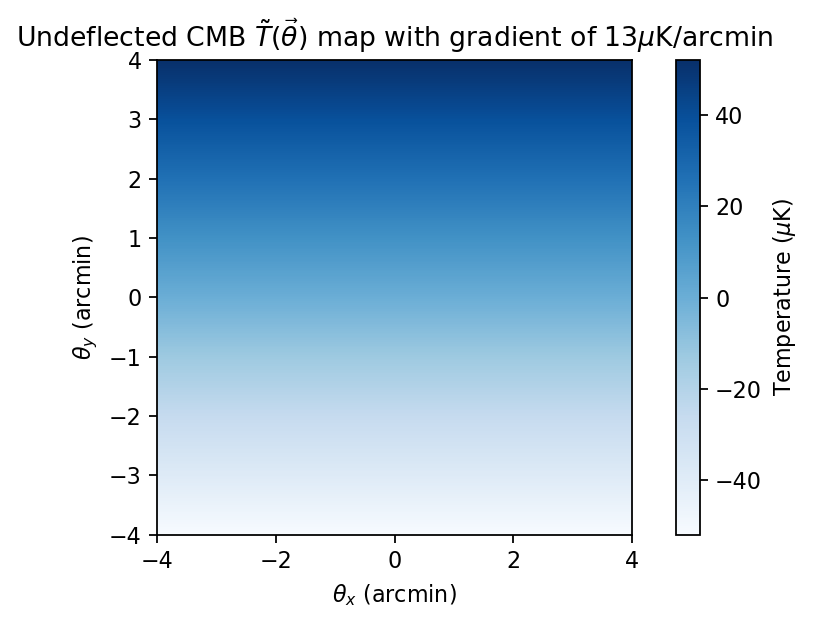

In [139]:
pix_size = 0.01
x = np.arange(-4, 4, pix_size)  #arcmin
y = np.arange(4, -4, -pix_size) #arcmin

x_mesh, y_mesh = np.meshgrid(x,y)

undeflected_cmb = y_mesh * 13 #\microK as gradient is 13\microK/arcmin

cmb_grad_x = x_mesh/x_mesh * 0   #\microK/arcmin
cmb_grad_y = y_mesh/y_mesh * 13  #\microK/arcmin

# cmb_grad_y, cmb_grad_x = np.gradient(-undeflected_cmb)

plt.figure(dpi=dpi)
plt.imshow(undeflected_cmb, cmap = 'Blues', extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r'Undeflected CMB $\~{T} (\vec{\theta})$ map with gradient of 13$\mu$K/arcmin')
plt.tight_layout()
# plt.savefig('undeflected_const_grad.pdf');

### Deflection angle space

/home/centro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


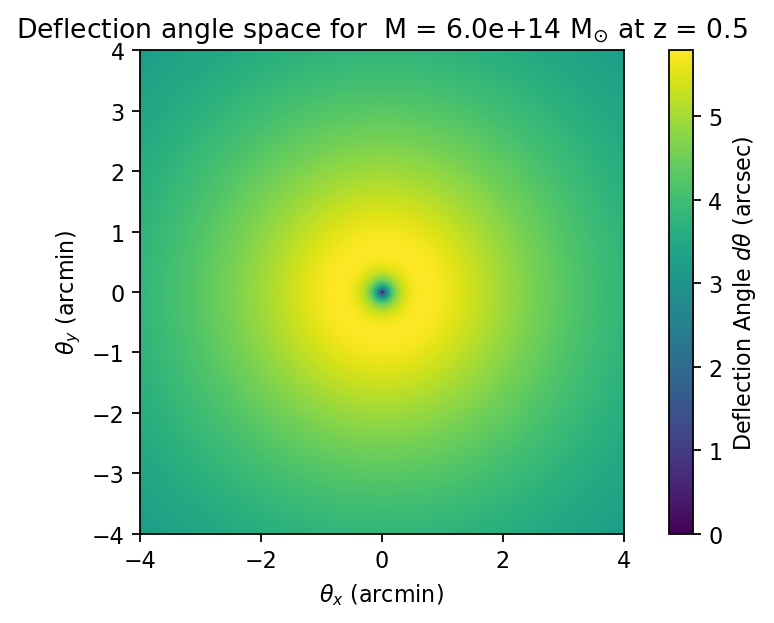

In [140]:
cosmology.setCosmology('planck18')

M_200 = 6e14 

z_l_1_0 = 0.5
c_200_4 = 4

theta = np.radians(np.sqrt(y_mesh**2 + x_mesh**2) / 60)  #radians
r = theta * comov_dist_func(z_l_1_0)                     #Mpc
d_theta = d_theta_dodelson(r, M_200, z_l_1_0, c_200_4)   #arcsec

d_theta[int(d_theta.shape[0]/2), int(d_theta.shape[1]/2)] = d_theta_dodelson((x[1]-x[0])/4, 
                        M_200, z_l_1_0, c_200 = c_200_4)

plt.figure(dpi=dpi)
plt.imshow(d_theta, extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])
plt.colorbar(label = r'Deflection Angle $d\theta$ (arcsec)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title('Deflection angle space for '+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$' + ' at z = {}'.format(z_l_1_0))
plt.tight_layout()
# plt.savefig('deflection_space_8_x_8.pdf');

### Deflected CMB map
Eq. 9 of Vale (2004)
$$
T(\boldsymbol{\theta}) \approx \tilde{T}(\boldsymbol{\theta})-\delta \boldsymbol{\theta} \cdot \nabla \tilde{T}(\boldsymbol{\theta})
$$

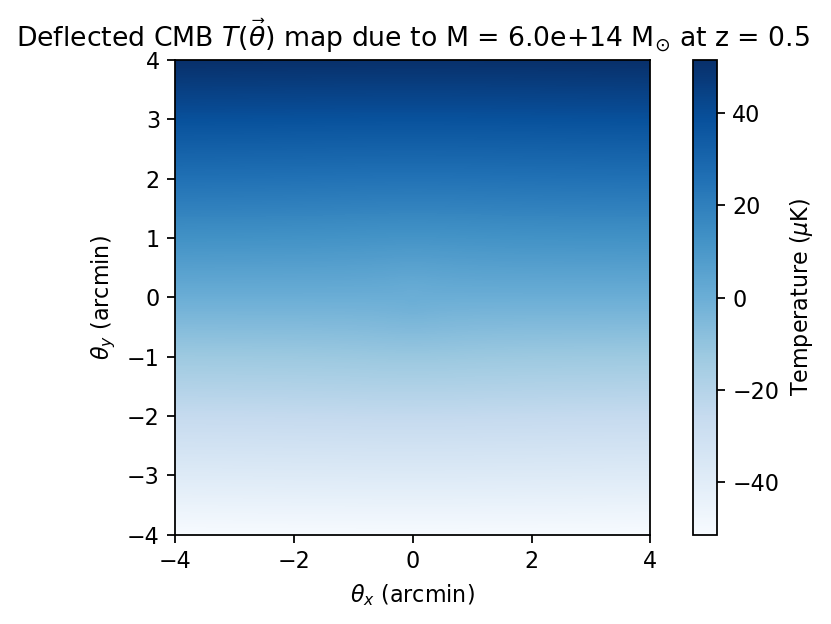

In [141]:
theta_in_arcsec = np.sqrt(y_mesh**2 + x_mesh**2)

d_theta_x = -d_theta * x_mesh/theta_in_arcsec
d_theta_y = -d_theta * y_mesh/theta_in_arcsec

deflected_cmb = undeflected_cmb + (d_theta_x/60 * cmb_grad_x + d_theta_y/60 * cmb_grad_y)

plt.figure(dpi=dpi)
plt.imshow(deflected_cmb, cmap = 'Blues', extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r'Deflected CMB $T(\vec{\theta})$ map due to'+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$' +' at z ='+' {}'.format(z_l_1_0))
plt.tight_layout()
# plt.savefig('deflected_const_grad.pdf');

### Cluster-CMB lensing signal map for c = 4
Eq. 12 of Vale (2004)
$$
\Delta T(\boldsymbol{\theta}) \equiv T(\boldsymbol{\theta})-\tilde{T}(\boldsymbol{\theta})
$$

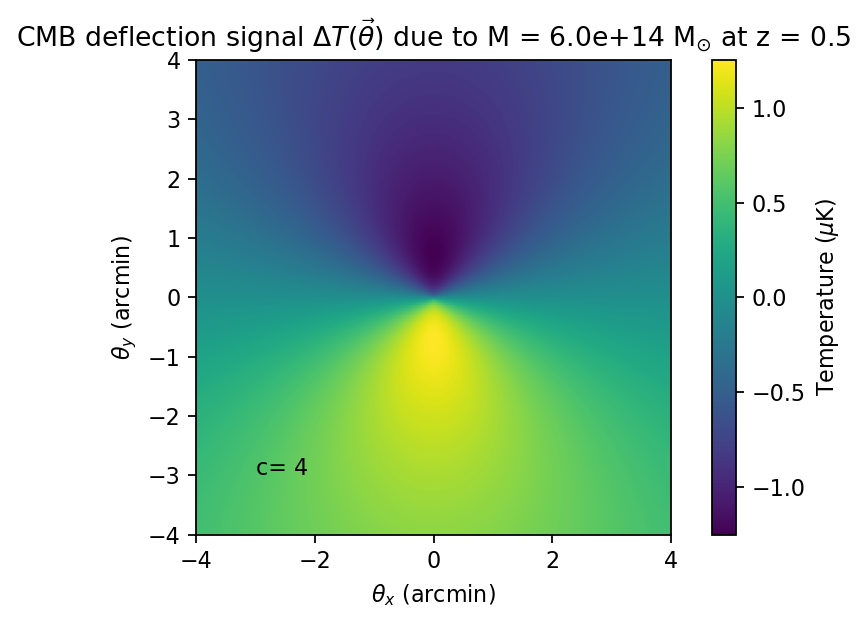

In [142]:
cosmology.setCosmology('planck18')

signal_1 =  d_theta_y/60 * cmb_grad_y
# signal = deflected_cmb - undeflected_cmb

plt.figure(dpi=dpi)
plt.imshow(signal_1,  extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r'CMB deflection signal $\Delta{T}(\vec{\theta})$ due to'+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$'+' at z ='+' {}'.format(z_l_1_0))
plt.text(-3,-3, 'c= {}'.format(c_200_4))
plt.tight_layout()
# plt.savefig('signal_c_4.pdf');

### Cluster-CMB lensing signal map for c = 8

/home/centro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


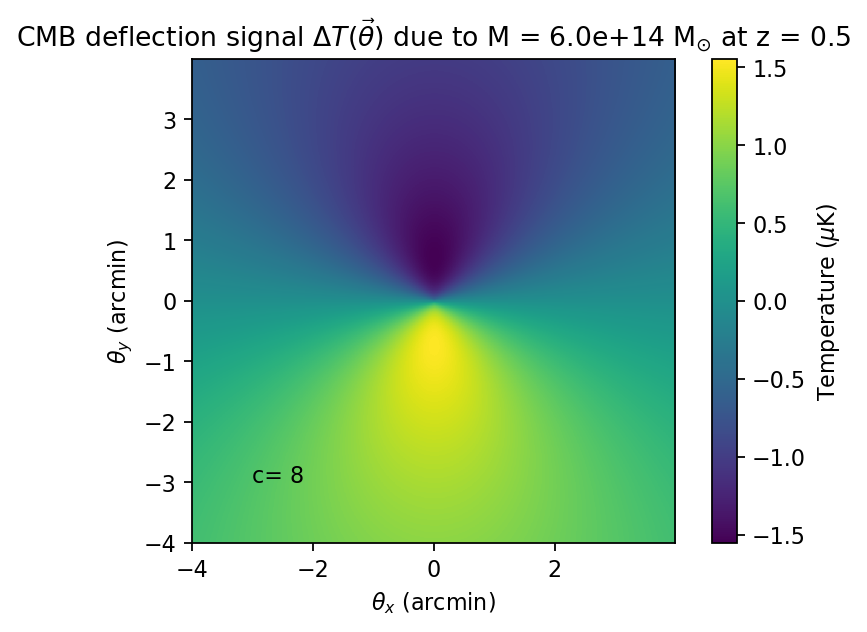

In [143]:
cosmology.setCosmology('planck18')

z_l_2_0 = 0.5
c_200_8 = 8
d_theta = d_theta_dodelson(r, M_200, z_l_2_0, c_200_8)  #arcsec
d_theta[int(d_theta.shape[0]/2), int(d_theta.shape[1]/2)] = d_theta_dodelson((x[1]-x[0])/4,
                             M_200, z_l_2_0, c_200 = c_200_8)

d_theta_y = -d_theta * y_mesh/theta_in_arcsec

signal_2 =  d_theta_y/60 * cmb_grad_y

plt.figure(dpi=dpi)
plt.imshow(signal_2,  extent=[min(x),max(x),min(x),max(x)])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r'CMB deflection signal $\Delta{T}(\vec{\theta})$ due to'+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$'+' at z =' + ' {}'.format(z_l_2_0))
plt.text(-3,-3, 'c= {}'.format(c_200_8));

### Cluster-CMB lensing signal map c = 2

/home/centro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


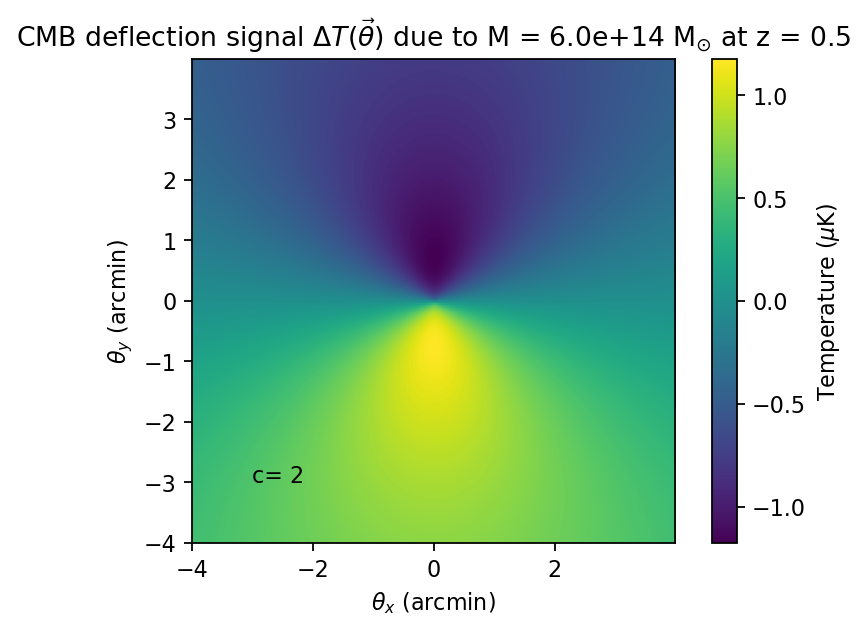

In [144]:
cosmology.setCosmology('planck18')

z_l_0_1 = 0.5
c_200_2 = 2
d_theta = d_theta_dodelson(r, M_200, z_l_0_1, c_200 = c_200_2)  #arcsec
d_theta[int(d_theta.shape[0]/2), int(d_theta.shape[1]/2)] = d_theta_dodelson((x[1]-x[0])/4, 
                M_200, z_l_0_1, c_200 = c_200_2)

d_theta_y = -d_theta * y_mesh/theta_in_arcsec

signal_3 =  d_theta_y/60 * cmb_grad_y

plt.figure(dpi=dpi)
plt.imshow(signal_3,  extent=[min(x),max(x),min(x),max(x)])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r'CMB deflection signal $\Delta{T}(\vec{\theta})$ due to'+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$'+' at z =' + ' {}'.format(z_l_0_1))
plt.text(-3,-3, 'c= {}'.format(c_200_2));

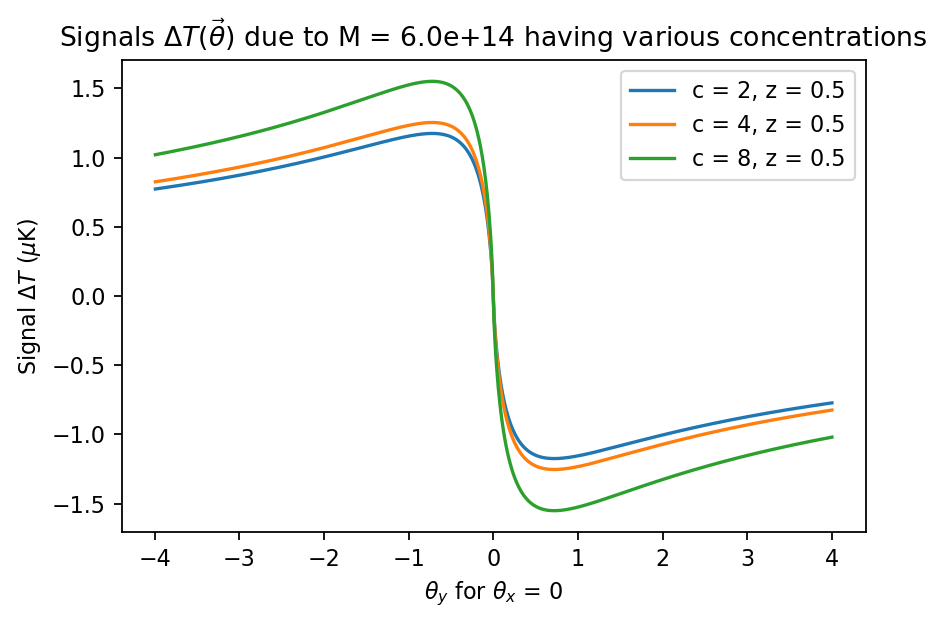

In [145]:
cosmology.setCosmology('planck18')
mid_column = int(signal_1.shape[1]/2)

plt.figure(dpi=dpi)

plt.plot(y_mesh[:,mid_column], signal_3[:,mid_column], 
        label = 'c = {}, '.format(c_200_2)
        + 'z = {}'.format(z_l_0_1))

plt.plot(y_mesh[:,mid_column], signal_1[:,mid_column], 
        label = 'c = {}, '.format(c_200_4)
        + 'z = {}'.format(z_l_1_0))

plt.plot(y_mesh[:,mid_column], signal_2[:,mid_column], 
        label = 'c = {}, '.format(c_200_8)
        + 'z = {}'.format(z_l_2_0))
        
plt.xlabel(r'$\theta_y$ for $\theta_x$ = 0')
plt.ylabel(r'Signal $\Delta T$ ($\mu$K)')
plt.legend()
plt.title(r'Signals $\Delta{T}(\vec{\theta})$ due to'+' M = {:.1e}'.format(M_200) 
+' having various concentrations')
plt.tight_layout()
# plt.savefig('signal_various_c.pdf');

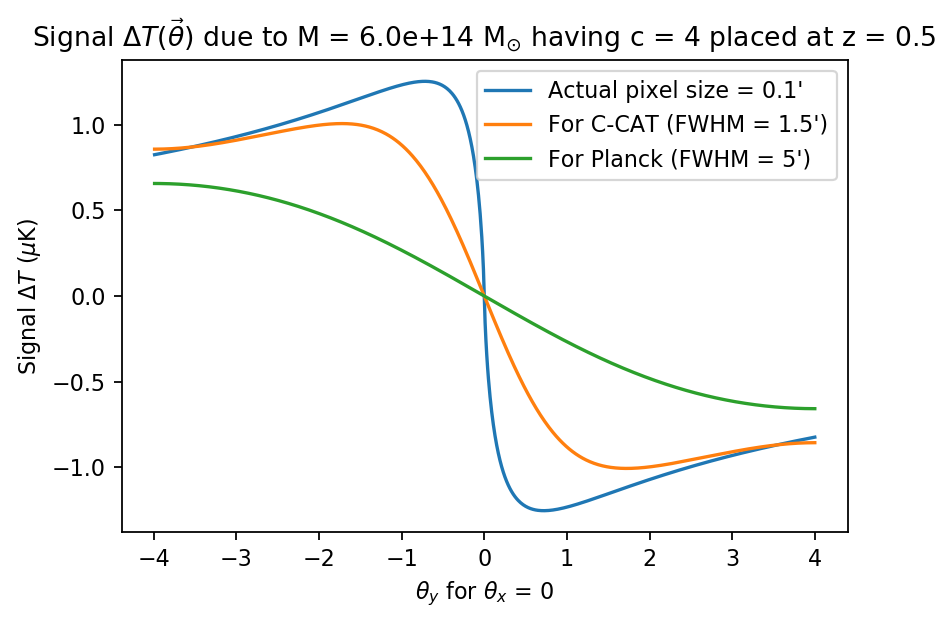

In [146]:
cosmology.setCosmology('planck18')
signal_1_convo_ccat = gaussian_filter(signal_1, sigma = 1.5/2.3548/pix_size)
signal_1_convo_planck = gaussian_filter(signal_1, sigma = 5/2.3548/pix_size)
mid_column = int(signal_1_convo_planck.shape[1]/2)

plt.figure(dpi=dpi)

plt.plot(y_mesh[:,mid_column], signal_1[:,mid_column], 
        label = "Actual pixel size = 0.1'")

plt.plot(y_mesh[:,mid_column], signal_1_convo_ccat[:,mid_column], 
        label = "For C-CAT (FWHM = 1.5')")

plt.plot(y_mesh[:,mid_column], signal_1_convo_planck[:,mid_column], 
        label = "For Planck (FWHM = 5')")

plt.xlabel(r'$\theta_y$ for $\theta_x$ = 0')
plt.ylabel(r'Signal $\Delta T$ ($\mu$K)')
plt.legend()
plt.title(r'Signal $\Delta{T}(\vec{\theta})$ due to'+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$ having c = 4'+' placed at z =' + ' {}'.format(z_l_0_1))
plt.tight_layout()
# plt.savefig('signal_various_c_convolved.pdf');

## Deflecting $\lambda$-CDM CMB by a galaxy cluster
**Importing libraries**

In [147]:
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import astropy.io.fits as fits
import matplotlib

### Plotting $\lambda$-CDM CMB power spectrum

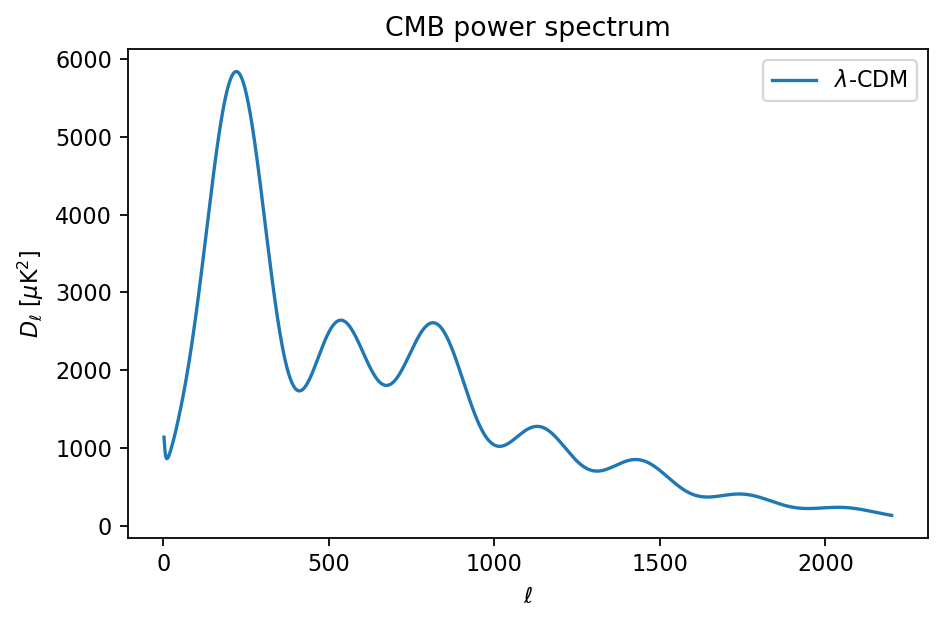

In [148]:
ell, DlTT = np.loadtxt("camb_39568229_scalcls.dat", usecols=(0, 1), unpack=True)
plt.figure(dpi=dpi)
plt.plot(ell,DlTT, label = '$\lambda$-CDM')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.title('CMB power spectrum')
plt.tight_layout()
# plt.savefig('power_spectrum.pdf');

### Setting parameters for 1$^\circ$ x 1$^\circ$ CMB map

This part of the code has been taken from: [https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_01.ipynb] (https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_01.ipynb)

In [149]:
## variables to set up the size of the map
N = 600# 2**9  # this is the number of pixels in a linear dimension
# N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.1 # size of a pixel in arcminutes
# pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -300  # minimum for color bar
c_max = 300   # maximum for color bar
X_width = N*pix_size  # horizontal map width in arcmin
Y_width = N*pix_size  # vertical map width in arcmin

### Generating 1$^\circ$ x 1$^\circ$ CMB map from above power spectrum

In [150]:
"makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
"the pixel size (pix_size) required and the number N of pixels in the linear dimension."
#np.random.seed(100)
# convert Dl to Cl
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
ClTT[1] = 0.

# make a 2D real space coordinate system
onesvec = np.ones(N)
inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
# compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
# in range(N), which is just N rows copies of inds - for the x dimension
X = np.outer(onesvec,inds) 
# compute the transpose for the y dimension
Y = -np.transpose(X)
# radial component R
R = np.sqrt(X**2. + Y**2.)

# now make a 2D CMB power spectrum
pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
ClTT_expanded = np.zeros(int(ell2d.max())+1) 
# making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

# the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
CLTT2d = ClTT_expanded[ell2d.astype(int)] 
#plt.imshow(np.log(CLTT2d))
    

# now make a realization of the CMB with the given power spectrum in real space
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 

FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
# plt.imshow(np.real(FT_2d))
    

## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
#Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###

# move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
# we only want to plot the real component
CMB_T = np.real(CMB_T)

### Plotting the CMB map

map mean: 29.279392198006086 map rms: 61.72707091034805


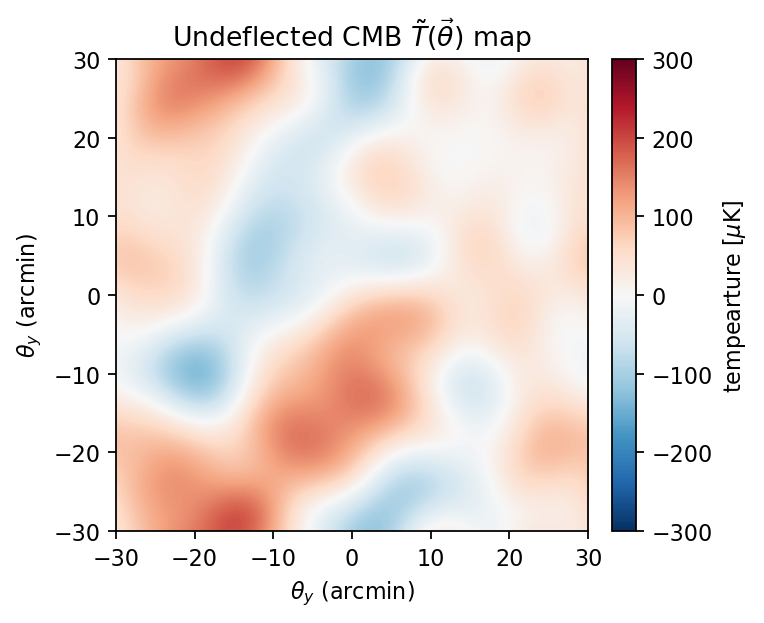

In [151]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("map mean:",np.mean(CMB_T),"map rms:",np.std(CMB_T))
plt.figure(dpi=dpi)
im = plt.imshow(CMB_T, interpolation='bilinear',cmap=cm.RdBu_r)
im.set_clim(c_min,c_max)
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.xlabel(r'$\theta_y$ (arcmin)')
plt.title(r'Undeflected CMB $\~{T}(\vec{\theta})$ map')

ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'tempearture [$\mu$K]', rotation=90)

X_arcmin = X*60
Y_arcmin = Y*60

im.set_extent([X_arcmin.min(),X_arcmin.max(),Y_arcmin.min(),Y_arcmin.max()])
plt.tight_layout()
# plt.savefig('undeflected_CMB_CDM.pdf');

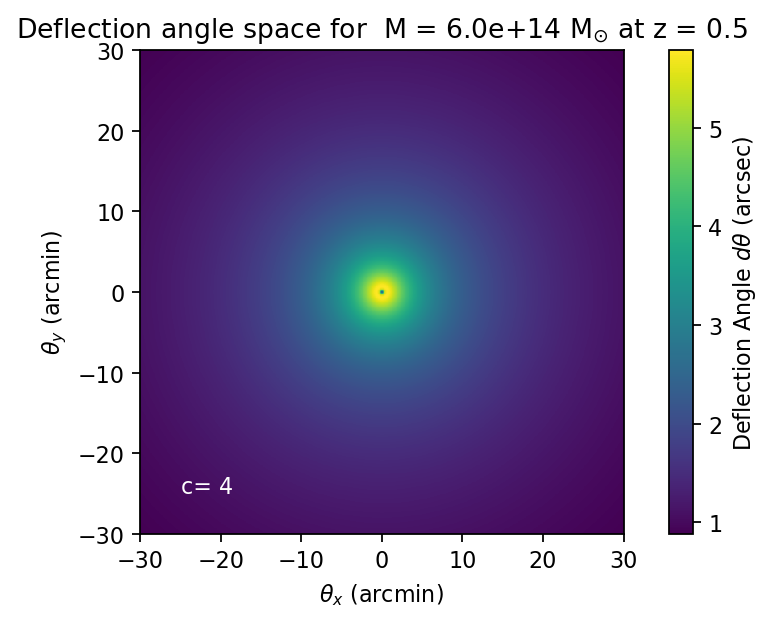

In [152]:
cosmology.setCosmology('planck18')

theta = np.radians(np.sqrt(X_arcmin**2 + Y_arcmin**2)/60)
r = theta * comov_dist_func(z_l_1_0)
d_theta = d_theta_dodelson(r, M_200, z_l_1_0, c_200_4) 

plt.figure(dpi=dpi)
plt.imshow(d_theta, extent=[X_arcmin.min(),X_arcmin.max(),Y_arcmin.min(),Y_arcmin.max()])
plt.colorbar(label = r'Deflection Angle $d\theta$ (arcsec)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title('Deflection angle space for '+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$' + ' at z = {}'.format(z_l_1_0))
plt.text(-25,-25, 'c= {}'.format(c_200_4), color = '1')
plt.tight_layout()
# plt.savefig('deflection_space_60_x_60.pdf');

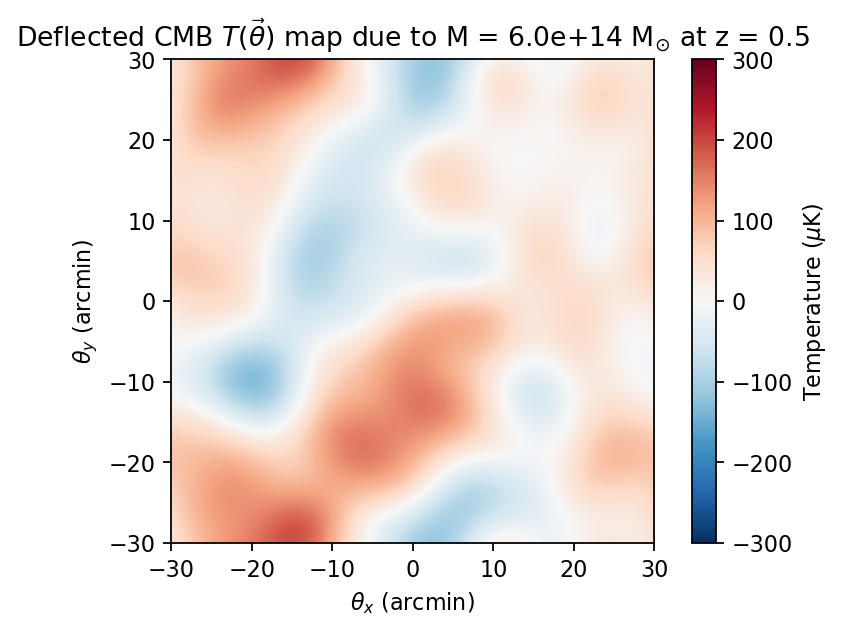

In [153]:
cmb_grad_y, cmb_grad_x = np.gradient(CMB_T, pix_size) # \microK/arcmin

theta_in_arcsec = np.sqrt(X_arcmin**2 + Y_arcmin**2)

d_theta_x = -d_theta * X_arcmin/theta_in_arcsec
d_theta_y = -d_theta * Y_arcmin/theta_in_arcsec

deflected_cmb = CMB_T + (d_theta_x/60 * cmb_grad_x + d_theta_y/60 * cmb_grad_y)

plt.figure(dpi=dpi)
plt.imshow(deflected_cmb, cmap = cm.RdBu_r, extent=[X_arcmin.min(),X_arcmin.max(),Y_arcmin.min(),Y_arcmin.max()],
             vmin= c_min, vmax = c_max)
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r'Deflected CMB $T(\vec{\theta})$ map due to'+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$' +' at z ='+' {}'.format(z_l_1_0));

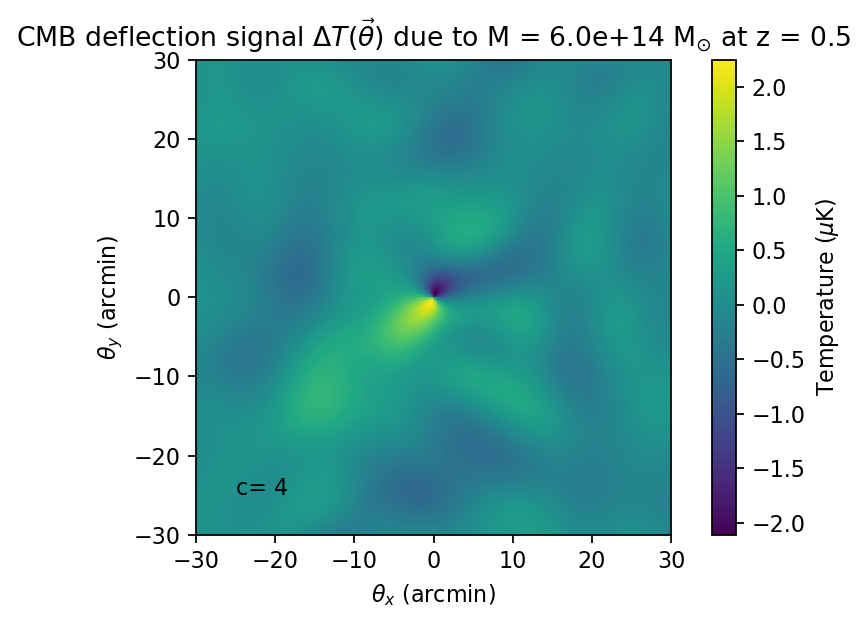

In [154]:
cosmology.setCosmology('planck18')

# signal =  d_theta_y/60 * cmb_grad_y
signal = deflected_cmb - CMB_T

plt.figure(dpi=dpi)
plt.imshow(signal,  extent=[X_arcmin.min(),X_arcmin.max(),Y_arcmin.min(),Y_arcmin.max()])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r'CMB deflection signal $\Delta{T}(\vec{\theta})$ due to'+' M = {:.1e}'.format(M_200) 
+ r' M$_{\odot}$'+' at z ='+' {}'.format(z_l_1_0))
plt.text(-25,-25, 'c= {}'.format(c_200_4), color = '0')
plt.tight_layout()
# plt.savefig('signal_map_CDM.pdf');

### Zooming in on inner 20' x 20'

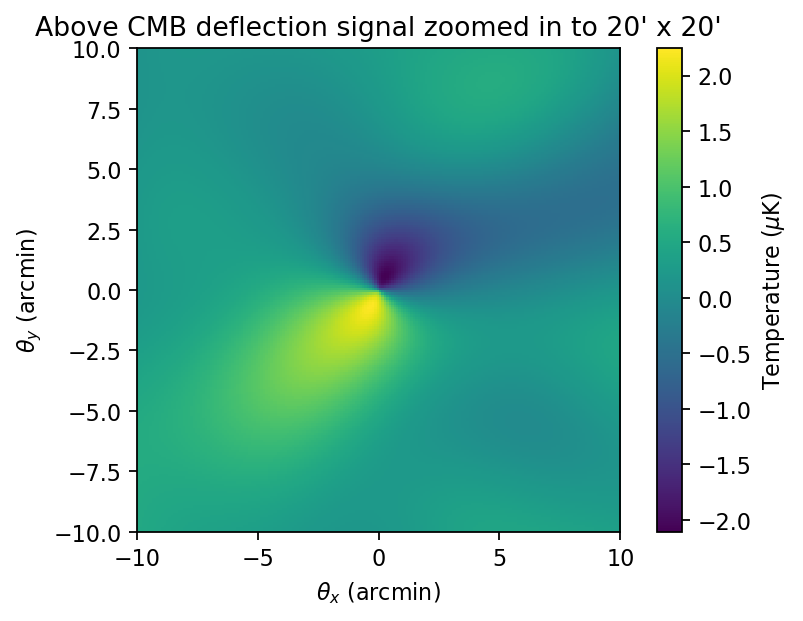

In [155]:
plt.figure(dpi=dpi)
plt.imshow(signal[int(N/3):int(N*2/3), int(N/3):int(N*2/3)],  
extent=[X_arcmin.min()/3,X_arcmin.max()/3,Y_arcmin.min()/3,Y_arcmin.max()/3])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r"Above CMB deflection signal zoomed in to 20' x 20'") ;

### Gaussian convolved signal for C-CAT (1.5')

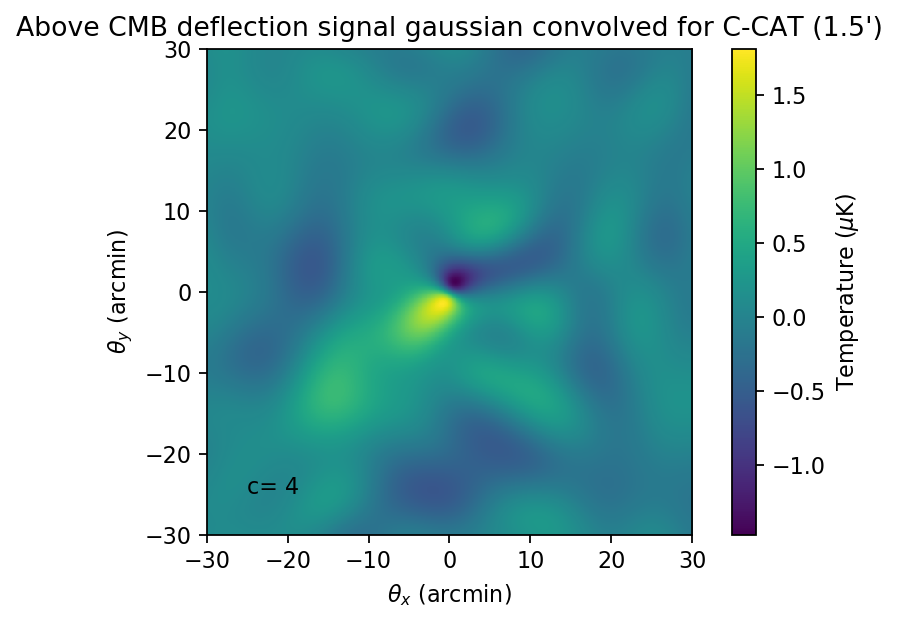

In [156]:
signal_convo_ccat = gaussian_filter(signal, sigma = 1.5/2.3548/pix_size)

plt.figure(dpi=dpi)
plt.imshow(signal_convo_ccat,  extent=[X_arcmin.min(),X_arcmin.max(),Y_arcmin.min(),Y_arcmin.max()])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r"Above CMB deflection signal gaussian convolved for C-CAT (1.5')" )
plt.text(-25,-25, 'c= {}'.format(c_200_4), color = '0')
plt.tight_layout()
# plt.savefig('signal_CCAT_CDM.pdf');

### Gaussian convolved signal for Planck (5')

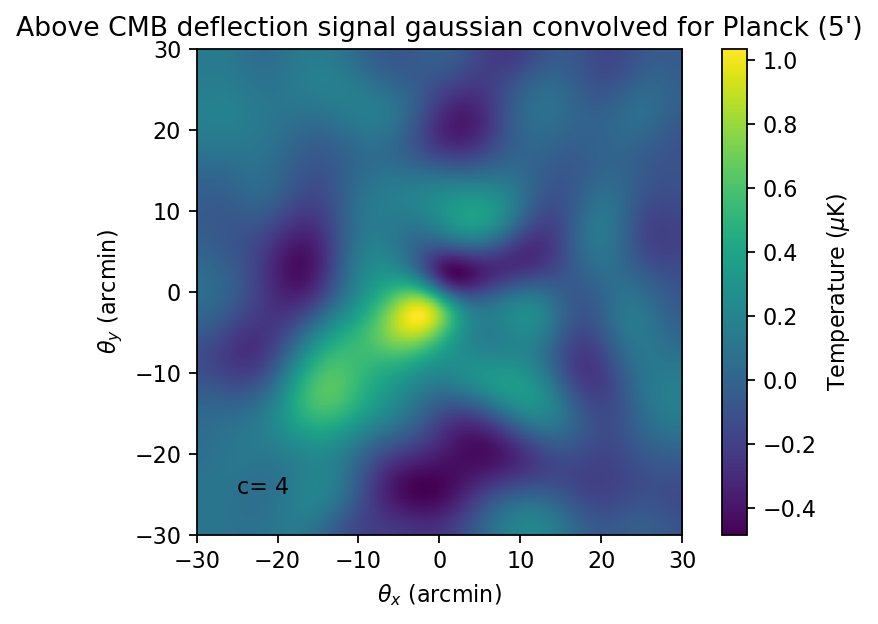

In [157]:
signal_convo_planck = gaussian_filter(signal, sigma = 5/2.3548/pix_size)

plt.figure(dpi=dpi)
plt.imshow(signal_convo_planck,  extent=[X_arcmin.min(),X_arcmin.max(),Y_arcmin.min(),Y_arcmin.max()])
plt.colorbar(label = 'Temperature ($\mu$K)')
plt.xlabel(r'$\theta_x$ (arcmin)')
plt.ylabel(r'$\theta_y$ (arcmin)')
plt.title(r"Above CMB deflection signal gaussian convolved for Planck (5')" )
plt.text(-25,-25, 'c= {}'.format(c_200_4), color = '0')
plt.tight_layout()
# plt.savefig('signal_planck_CDM.pdf');